Mounted at /content/drive


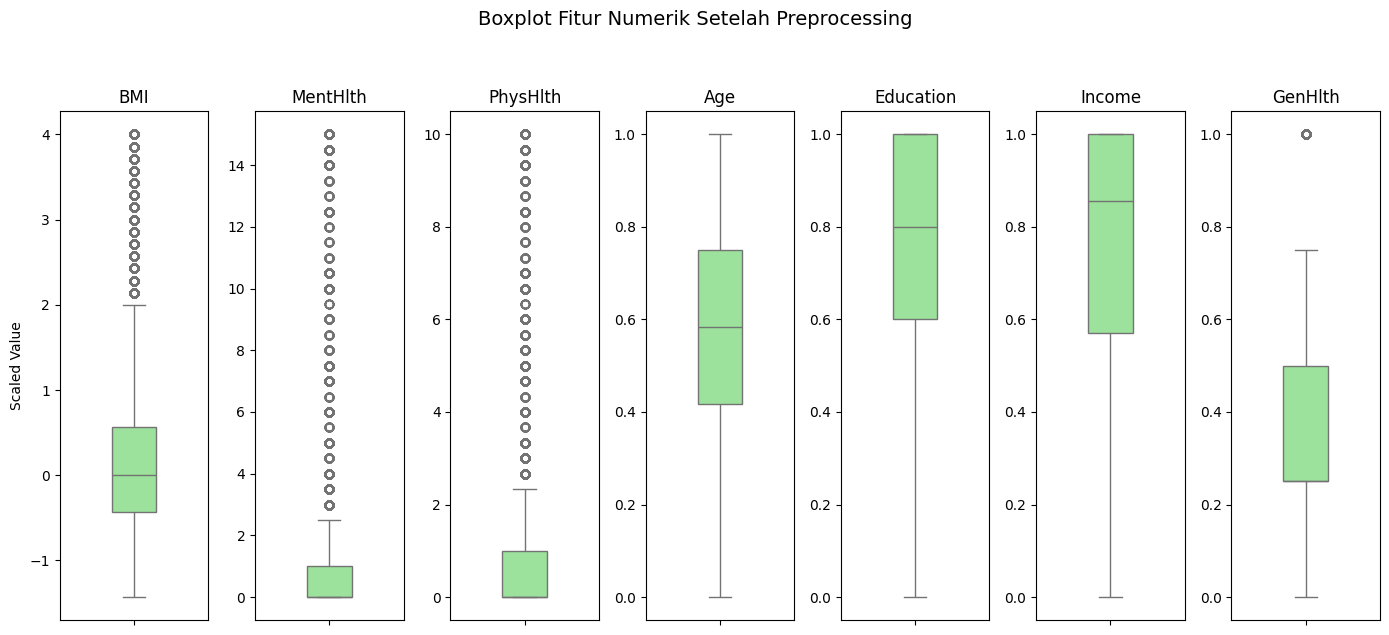

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8428 - loss: 0.4302 - val_accuracy: 0.8479 - val_loss: 0.3966
Epoch 2/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8472 - loss: 0.4001 - val_accuracy: 0.8485 - val_loss: 0.3946
Epoch 3/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8476 - loss: 0.3982 - val_accuracy: 0.8493 - val_loss: 0.3942
Epoch 4/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8479 - loss: 0.3973 - val_accuracy: 0.8494 - val_loss: 0.3937
Epoch 5/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8481 - loss: 0.3966 - val_accuracy: 0.8496 - val_loss: 0.3935
Epoch 6/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8485 - loss: 0.3961 - val_accuracy: 0.8500 - val_loss: 0.3934
Epoch 7/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8486 - loss: 0.3957 - val_accuracy: 0.8494 - val_loss: 0.3937
Epoch 8/100
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8487 -

In [1]:
 # 0. Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1. Import Libraries
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats.mstats import winsorize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# 2. Set Seed untuk Konsistensi
SEED = 43
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 3. Load Dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset/diabetes_012_health_indicators_BRFSS2015.csv')
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']

# 4. Preprocessing
## 4.1 Winsorizing untuk fitur BMI (0.5%-99.5%)
X['BMI'] = winsorize(X['BMI'], limits=[0.005, 0.005])

## 4.2 Cap untuk fitur MentHlth & PhysHlth (batas atas 30)
X['MentHlth'] = np.where(X['MentHlth'] > 30, 30, X['MentHlth'])
X['PhysHlth'] = np.where(X['PhysHlth'] > 30, 30, X['PhysHlth'])

## 4.3 Definisi fitur scaler
robust_features = ['BMI', 'MentHlth', 'PhysHlth']
minmax_features = ['Age', 'Education', 'Income', 'GenHlth']

## 4.4 Terapkan Scalers
scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()

X[robust_features] = scaler_robust.fit_transform(X[robust_features])
X[minmax_features] = scaler_minmax.fit_transform(X[minmax_features])

# 5. Visualisasi Boxplot Setelah Preprocessing
numeric_feats = robust_features + minmax_features

plt.figure(figsize=(14, 6))
for i, feature in enumerate(numeric_feats):
    plt.subplot(1, len(numeric_feats), i+1)
    sns.boxplot(y=X[feature], color='lightgreen', width=0.3)
    plt.title(f'{feature}')
    plt.xlabel('')
    plt.ylabel('Scaled Value' if i == 0 else '')
plt.suptitle('Boxplot Fitur Numerik Setelah Preprocessing', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# 6. One-hot Encoding untuk Target
y_encoded = to_categorical(y)

# 7. Split Data (Train/Test lalu Train/Validation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=SEED, stratify=y
)
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train.argmax(axis=1)
)

# 8. Build Baseline DNN Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 9. Train Model
history = model.fit(
    X_train_main, y_train_main,
    validation_data=(X_val, y_val),
    epochs=100,
    verbose=1
)

# 10. Evaluate on Test Set
y_pred_prob = model.predict(X_test)
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_true_class = np.argmax(y_test, axis=1)

# 11. Metrik Evaluasi
print("\n=== Classification Report (Macro) Model Default Seed 43 ===")
print(classification_report(y_true_class, y_pred_class, digits=4))
roc_auc = roc_auc_score(y_test, y_pred_prob, average='macro', multi_class='ovr')
print(f"\nMacro-average ROC AUC: {roc_auc:.4f}")
